In [2]:
%%capture
! git clone https://github.com/arch-raven/Mosaic2k21.git

In [3]:
%load_ext autoreload
%autoreload 2
%cd Mosaic2k21/

In [7]:
import sys  
sys.path.insert(1, '/content/Mosaic2k21/src')

In [28]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

from utils import get_random_plate, display
from classifier import ReadPlate
from perspective_transform import perspectiveTransform
from segmentation import segment_characters

readPlate = ReadPlate(
    digits_path = 'models/digits-v6-20.h5',
    alphabets_path='models/alphabets-v6.h5',
    all36_path='models/all36-v6-20.h5',
)

def segmentAndReadPlate(
    plate=None,  
    clahe_clipLimit=3,
    clahe_tileGridSize=16,
    erosion_iters=1, 
    dilation_iters=1, 
    do_perspective_transform=True, 
    verbose=1,
    return_results=False,
):
    
    if plate is None:
        plate = get_random_plate()
    elif type(plate)==str:
        plate = cv2.imread(plate)
    
    if verbose>=3: 
        display(plate)
    
    if do_perspective_transform: 
        plate = perspectiveTransform(
            plate, 
            clahe_clipLimit=3,
            clahe_tileGridSize=16,
            erosion_iters=0, 
            dilation_iters=5,
            show_contours = verbose>=3, 
            show_corners = verbose>=3, 
        )
    
    char = segment_characters(
        plate, 
        clahe_clipLimit=clahe_clipLimit, 
        clahe_tileGridSize=clahe_tileGridSize, 
        erosion_iters=erosion_iters, 
        dilation_iters=dilation_iters,
        display_verbose=verbose,
    )
    fixed_char, preds = readPlate.predict_char(char)

    if verbose>=3:
        print(len(fixed_char), len(preds))
    
    if verbose>=1:
        plt.figure()
        for i in range(len(fixed_char)):
            fig = plt.subplot(1, len(fixed_char), i+1)
            fig.imshow(fixed_char[i], cmap=plt.cm.binary)
            fig.set_title(preds[i])
            fig.axis('off')
        plt.show()
    if return_results:
        return preds

In [41]:
seq_configs = [
    {"clahe_clipLimit":3, "erosion_iters":1, "dilation_iters":1, "clahe_tileGridSize":16, "do_perspective_transform":True},
    {"clahe_clipLimit":1, "erosion_iters":1, "dilation_iters":3, "clahe_tileGridSize":16, "do_perspective_transform":True},
    {"clahe_clipLimit":3, "erosion_iters":1, "dilation_iters":5, "clahe_tileGridSize":16, "do_perspective_transform":True},
]

def completePipeline(plate):
    best_res = 0
    for i in range(len(seq_configs)):
        res = segmentAndReadPlate(plate, verbose=0, return_results=True, **seq_configs[i])
        if 9<=len(res)<=11:
            best_res = i
            break
    # print(f"best_res idx: {best_res}")
    return segmentAndReadPlate(plate, verbose=1, return_results=True, **seq_configs[best_res])

In [29]:
test_images = glob('test_pics/t*.png')
test_images = sorted(test_images, key=lambda x:int(x.split('.')[-2].split('t')[-1]))
print(len(test_images))

17


test_pics/t1.png
best_res idx: 0


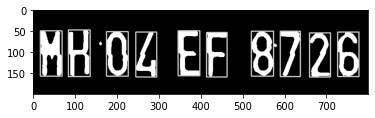

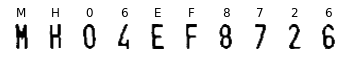

**************************************************




test_pics/t2.png
best_res idx: 0


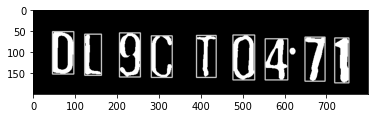

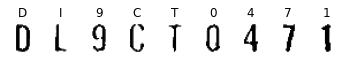

**************************************************




test_pics/t4.png
best_res idx: 1


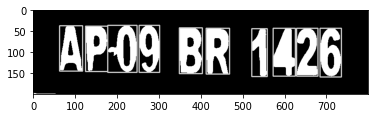

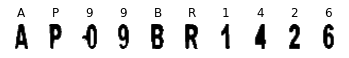

**************************************************




test_pics/t5.png
best_res idx: 0


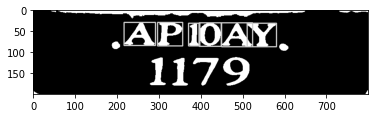

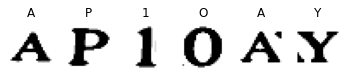

**************************************************




test_pics/t6.png
best_res idx: 0


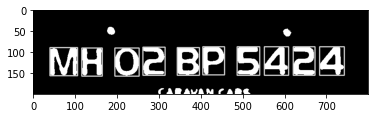

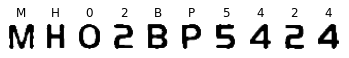

**************************************************




test_pics/t7.png
best_res idx: 0


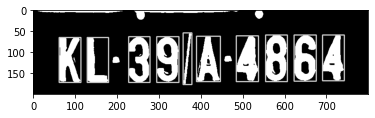

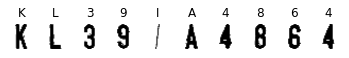

**************************************************




test_pics/t8.png
best_res idx: 0


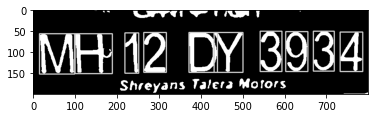

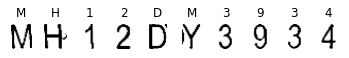

**************************************************




test_pics/t9.png
best_res idx: 0


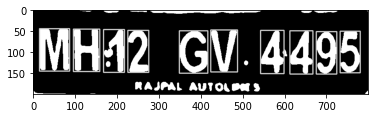

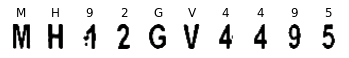

**************************************************




test_pics/t10.png
best_res idx: 0


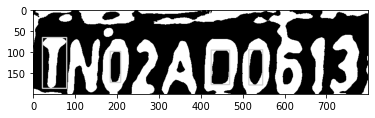

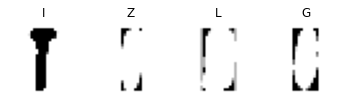

**************************************************




test_pics/t11.png
best_res idx: 0


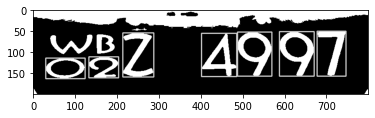

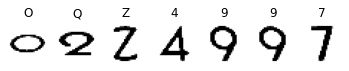

**************************************************




test_pics/t12.png
best_res idx: 0


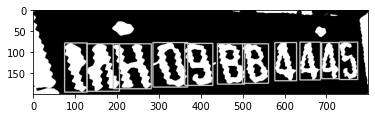

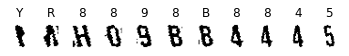

**************************************************




test_pics/t13.png
best_res idx: 0


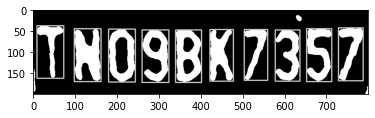

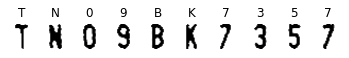

**************************************************




test_pics/t14.png
best_res idx: 0


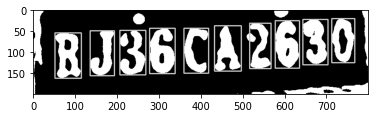

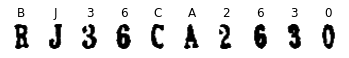

**************************************************




test_pics/t15.png
best_res idx: 0


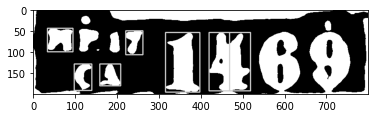

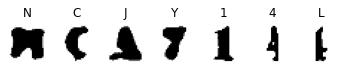

**************************************************




test_pics/t16.png
best_res idx: 1


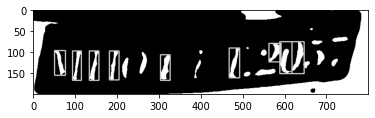

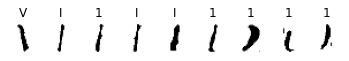

**************************************************




test_pics/t18.png
best_res idx: 0


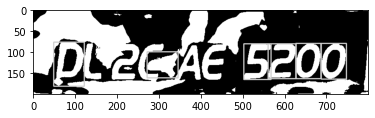

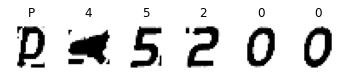

**************************************************




test_pics/t19.png
best_res idx: 0


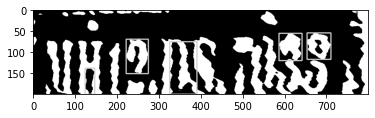

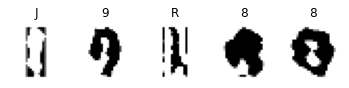

**************************************************






In [38]:
  for plate in test_images:
    print(plate)
    pred = completePipeline(plate)
    print('*'*50+'\n'*4)